In [115]:
import numpy as np
from pathlib import Path
import os
# set here the directory of the logged folder
os.chdir('/home/sunita/IDP/Code/Repo/di-lab' + 
         '/reports/shallow_model_2018_12_03_15_05')
import matplotlib.pyplot as plt
import torch
# import here the correct model file and the correct class name
import models.model_superclass as shallow
#as cnn_skipC_model
import pickle
from data.data_loader import ProcessData
model_name = 'shallow_model'
model_import_name = 'shallow_model__epoch_0.pt'

In [116]:
# specify comparison file
read_file = ( '/home/sunita/IDP/Code/Repo/di-lab' + 
            '/data/homo/processed/processed_all/optoacoustic/OA_Study26_Scan_16')

#load test files

#load config.json file

# initialize the data_loader


data_loader = ProcessData(process_raw_data=False,data_type='homo',do_augment=False, add_augment=False,
                          image_type='OA', get_scale_center=False, single_sample=True,
                          train_ratio=0.1)



['/home/sunita/IDP/Code/Repo/di-lab/data/homo/processed/processed_all/optoacoustic/OA_OptimalSoS5frames_Scan_49']
['/home/sunita/IDP/Code/Repo/di-lab/data/homo/processed/processed_all/optoacoustic/OA_OptimalSoS5frames_Scan_49']


In [117]:
# initialize the model and load saved parametersprint()

the_model = shallow.ImageTranslator(conv_channels=[28, 32, 64, 128, 256], strides=[1, 2, 1, 2], kernels=[(7,7) for i in range(4)], padding=[3,3,3,3])

if torch.cuda.is_available():
    the_model.load_state_dict(torch.load(model_import_name))
else:
    the_model.load_state_dict(torch.load(model_import_name, map_location='cpu'))
# set the state of the model to eval()
the_model.eval()

RuntimeError: cuda runtime error (4) : unspecified launch failure at /opt/conda/conda-bld/pytorch_1535491974311/work/aten/src/THC/generic/THCTensorCopy.cpp:20

In [95]:
def plot_us_channel(im_input, im_target, im_predict):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('input image')
    plt.imshow(im_input[:,:], cmap = 'gray')


    plt.subplot(1,3,2)
    plt.title('target image')
    plt.imshow(im_target[:,:], cmap = 'gray')
    
    plt.subplot(1,3,3)
    plt.title('predict image')
    plt.imshow(im_predict[:,:], cmap = 'gray')
    

In [96]:
def plot_oa_channel(im_input, im_target, im_predict):
    for i in range(2):
        plt.figure(figsize=(15,15))
        plt.subplot(1,3,1)
        plt.title('input image channel:' + str(i))
        plt.imshow(im_input[:,:,i], cmap = 'gray')


        plt.subplot(1,3,2)
        plt.title('target image channel:' + str(i))
        plt.imshow(im_target[:,:,i], cmap = 'gray')
    
      
        plt.subplot(1,3,3)
        plt.title('predict image channel:' + str(i))
        plt.imshow(im_predict[:,:,i], cmap = 'gray')

In [97]:
def plot_oa_spectra(im_input, im_target, im_predict, x, y):
    for i in range(2):
        print(im_predict.shape)
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.title('input image pixel:'  + str(x + i) + ', ' + str(y))
        plt.plot(im_input[x+i,y,:])

        plt.subplot(1,3,2)
        plt.title('target image pixel:'  + str(x + i) + ', ' + str(y))
        plt.plot(im_target[x+i,y,:])
        
     
        plt.subplot(1,3,3)
        plt.title('predicted image pixel:'  + str(x + i) + ', ' + str(y))
        plt.plot(im_predict[x+i,y,:])

In [98]:
scale_params_low, scale_params_high = data_loader.load_params(param_type="scale_params", dir_params='')
mean_image_low, mean_image_high = data_loader.load_params(param_type="mean_images", dir_params='')

In [99]:
target_im = data_loader._load_file_to_numpy(full_file_name=read_file, image_sign=data_loader.image_type +'_high')
input_im = data_loader._load_file_to_numpy(full_file_name=read_file, image_sign=data_loader.image_type + '_low')
print(input_im.shape)
np.expand_dims(input_im, axis=0).shape

(401, 401, 28)


(1, 401, 401, 28)

In [100]:
scale_center_X = data_loader.scale_and_center(np.expand_dims(input_im, axis=0), scale_params_low, mean_image_low)

print(scale_center_X.shape)
if data_loader.image_type == 'US':
    scale_center_X = scale_center_X.reshape(scale_center_X.shape[1], scale_center_X.shape[0],
                                        scale_center_X.shape[2], scale_center_X.shape[3])
    
else:
    scale_center_X = np.moveaxis(scale_center_X, [0, 1, 2, 3], [0, 2, 3, 1])
    print(scale_center_X.shape)
    

(1, 401, 401, 28)
(1, 28, 401, 401)


In [101]:
predict_im = the_model(torch.from_numpy(scale_center_X))


In [102]:
print(predict_im.shape)


torch.Size([1, 28, 401, 401])


In [103]:
predict_new = predict_im.detach().numpy()
predict_new = np.moveaxis(predict_new, [0, 2, 3, 1] , [0, 1, 2, 3])
print(predict_new.shape)
predict_rescaled = data_loader.scale_and_center_reverse(predict_new,
                                                  scale_params_high, mean_image_high)

print(predict_rescaled.shape)

(1, 401, 401, 28)
(1, 401, 401, 28)


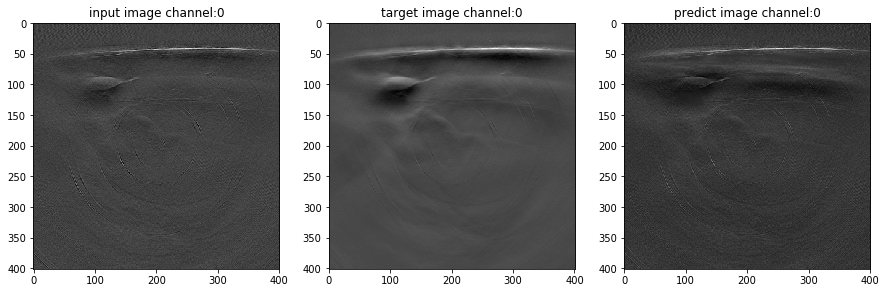

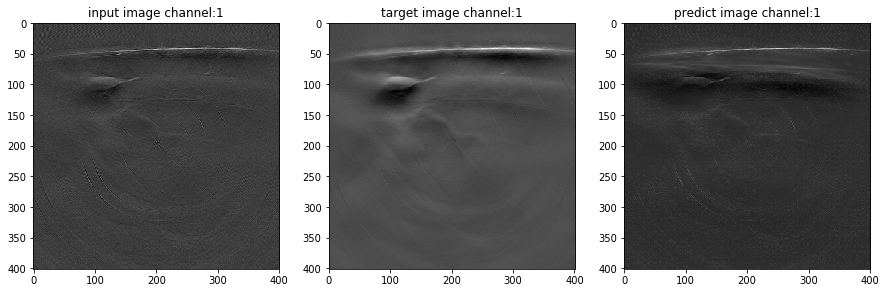

In [104]:
plot_oa_channel(im_input=input_im, im_target=target_im, im_predict=predict_rescaled[0,:,:,:])

(401, 401, 28)
(401, 401, 28)


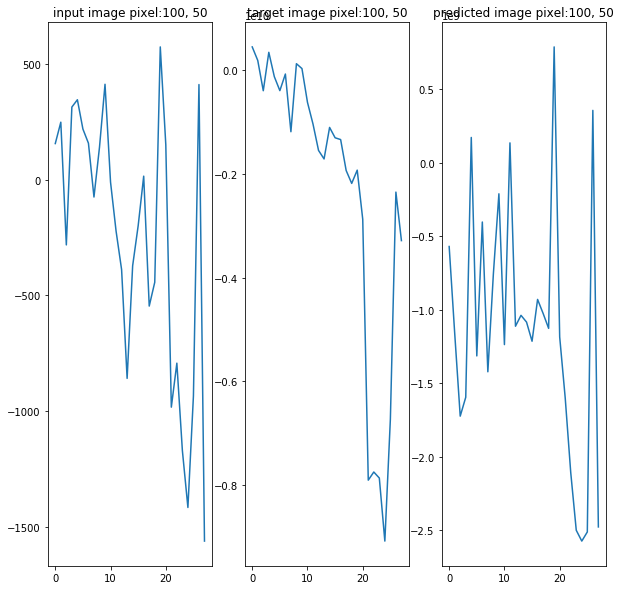

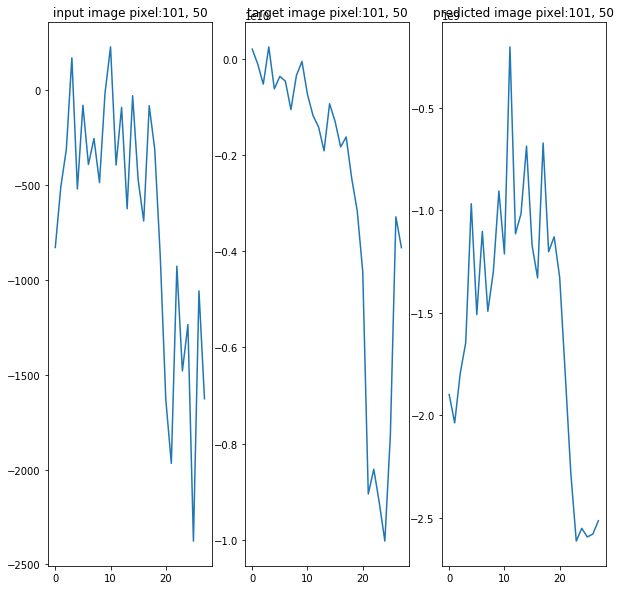

In [105]:
plot_oa_spectra(im_input=input_im, im_target=target_im, im_predict=predict_rescaled[0,:,:,:],x=100,y=50)

[0.14696996 0.10493114 0.04814452 0.01784016 0.01195675 0.01053962
 0.00980415 0.00942063 0.00932123 0.00921472 0.00913974 0.00910036]


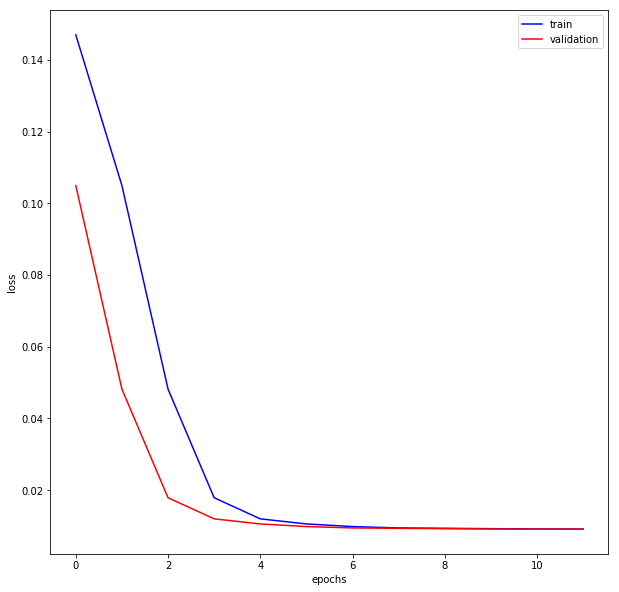

In [111]:
#loss curves
train_loss = np.load(the_model.model_name + '_train_loss.npy')
val_loss = np.load(the_model.model_name + '_validation_loss.npy')

print(train_loss)

plt.figure(figsize=(10,10))


plt.plot(train_loss,'-b', label='train')
plt.plot(val_loss, '-r', label='validation')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
